In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
tf.config.list_physical_devices('GPU')

2024-05-21 15:54:07.340953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 15:54:07.341022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 15:54:07.342484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 15:54:07.351802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 15:54:08.517351: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_dir = '../../Dataset_Scripts/Datasets/Dataset_R2/train/circles/'
test_dir = '../../Dataset_Scripts/Datasets/Dataset_R2/test/circles/'

In [3]:
IMG_SIZE = 250
BATCH_SIZE = 32

In [4]:
import pandas as pd
data_df = pd.read_csv('../../Dataset_Scripts/Datasets/Dataset_R2/data/circles_big.csv')
train_df = data_df[data_df['Variant'] == 'Train']
test_df = data_df[data_df['Variant'] == 'Test']

In [5]:
# Remove other columns and keep only the 'Proportion' and Filename columns
train_df = train_df[['Proportion', 'Filename']]
test_df = test_df[['Proportion', 'Filename']]

In [6]:
print(train_df.head())

   Proportion       Filename
0       1.250  circles_1.png
1       1.027  circles_2.png
2       2.406  circles_3.png
3       3.330  circles_4.png
4       3.258  circles_5.png


In [7]:
gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = gen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='Filename',
    y_col='Proportion',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = gen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='Filename',
    y_col='Proportion',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 10999 validated image filenames.
Found 4999 validated image filenames.


In [8]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(1)(x) 
model = keras.Model(inputs=inputs, outputs=outputs)

2024-05-21 15:54:19.133871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 15:54:19.134191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 15:54:19.134365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
model.compile(loss="mse", optimizer="adam" , metrics=["mae"])

In [10]:
checkpoint_filepath = 'models/R2/ch-{epoch:03d}.ckpt'
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

callbacks = [model_checkpoint, early_stop]


In [11]:
history = model.fit(train_generator, epochs=100, batch_size=32, verbose=1, validation_data=test_generator, callbacks=[callbacks])

Epoch 1/100


2024-05-21 15:54:25.257270: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-21 15:54:25.416190: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-21 15:54:27.303919: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-21 15:54:27.839272: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1248011520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 15:54:27.839318: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2024-05-21 15:54:27.846743: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716303267.980051  12706

344/344 [==============================] - ETA: 0s - loss: 73.5437 - mae: 3.7848
Epoch 1: val_loss improved from inf to 68.70406, saving model to models/R2/ch-001.ckpt
INFO:tensorflow:Assets written to: models/R2/ch-001.ckpt/assets


INFO:tensorflow:Assets written to: models/R2/ch-001.ckpt/assets


344/344 [==============================] - 97s 259ms/step - loss: 73.5437 - mae: 3.7848 - val_loss: 68.7041 - val_mae: 3.4713
Epoch 2/100
344/344 [==============================] - ETA: 0s - loss: 72.3799 - mae: 3.7805
Epoch 2: val_loss did not improve from 68.70406
344/344 [==============================] - 81s 234ms/step - loss: 72.3799 - mae: 3.7805 - val_loss: 68.7099 - val_mae: 3.4528
Epoch 3/100
344/344 [==============================] - ETA: 0s - loss: 72.2599 - mae: 3.8001
Epoch 3: val_loss did not improve from 68.70406
344/344 [==============================] - 80s 233ms/step - loss: 72.2599 - mae: 3.8001 - val_loss: 69.5913 - val_mae: 3.1594
Epoch 4/100
344/344 [==============================] - ETA: 0s - loss: 72.4176 - mae: 3.7704
Epoch 4: val_loss improved from 68.70406 to 68.56345, saving model to models/R2/ch-004.ckpt
INFO:tensorflow:Assets written to: models/R2/ch-004.ckpt/assets


INFO:tensorflow:Assets written to: models/R2/ch-004.ckpt/assets


344/344 [==============================] - 82s 238ms/step - loss: 72.4176 - mae: 3.7704 - val_loss: 68.5635 - val_mae: 3.6680
Epoch 5/100
344/344 [==============================] - ETA: 0s - loss: 72.4693 - mae: 3.7675
Epoch 5: val_loss did not improve from 68.56345
344/344 [==============================] - 82s 237ms/step - loss: 72.4693 - mae: 3.7675 - val_loss: 71.4596 - val_mae: 4.7587
Epoch 6/100
344/344 [==============================] - ETA: 0s - loss: 72.4072 - mae: 3.8135
Epoch 6: val_loss did not improve from 68.56345
344/344 [==============================] - 82s 237ms/step - loss: 72.4072 - mae: 3.8135 - val_loss: 69.2384 - val_mae: 3.2435
Epoch 7/100
344/344 [==============================] - ETA: 0s - loss: 72.2512 - mae: 3.7814
Epoch 7: val_loss did not improve from 68.56345
344/344 [==============================] - 81s 234ms/step - loss: 72.2512 - mae: 3.7814 - val_loss: 68.7421 - val_mae: 3.4977
Epoch 8/100
344/344 [==============================] - ETA: 0s - loss: 71

In [12]:
# save history to file
import pickle
with open('models/R2/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [13]:
# save model
model.save('models/R2/model.keras')

In [14]:
loss = model.evaluate(test_generator)

157/157 [==============================] - 26s 166ms/step - loss: 68.8413 - mae: 3.8893


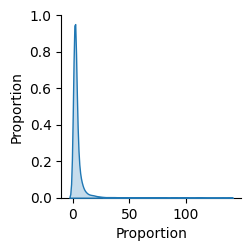

In [17]:
import seaborn as sns
sns.pairplot(train_df, diag_kind='kde')

In [18]:
new_genetator = gen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='Filename',
    y_col='Proportion',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=1,
)

Found 4999 validated image filenames.


In [19]:
# run thorugh all batches in the test generator and save predictions and true values into a csv
predictions = []
true_values = []

for i in range(len(new_genetator)):
    x, y = test_generator[i]
    predictions += list(model.predict(x).flatten())
    true_values += list(y)

1/1 [==============================] - 0s 94ms/step


ValueError: Asked to retrieve element 157, but the Sequence has length 157

In [20]:
df = pd.DataFrame({'True Area': true_values, 'Predicted Area': predictions, 'Difference': np.abs(np.array(true_values) - np.array(predictions))}, index=new_genetator.filenames)
df.to_csv('predictions.csv')

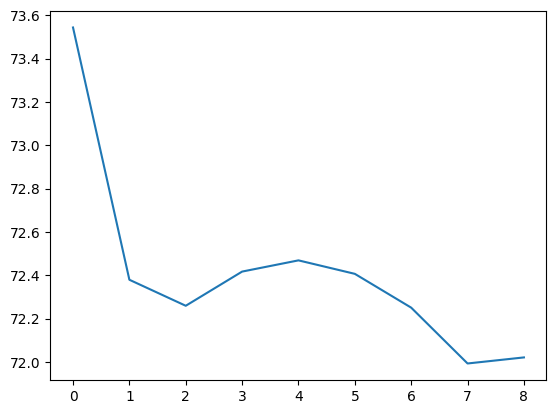

In [21]:
# plot of loss
plt.plot(history.history['loss'])
#plt.savefig('graphs/loss.png')

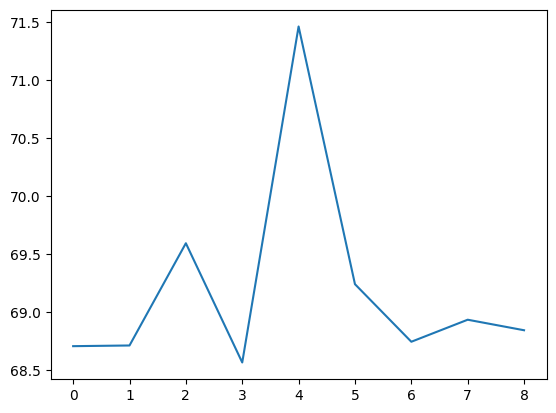

In [22]:
plt.plot(history.history['val_loss'])

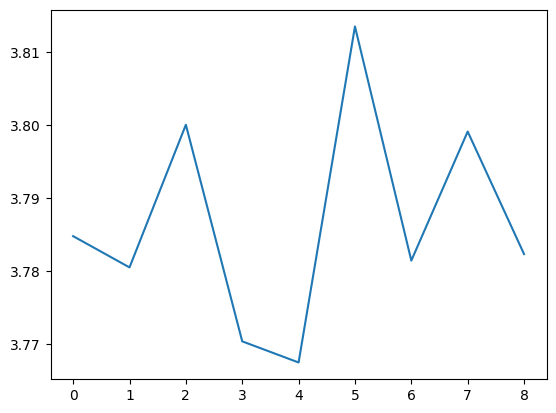

In [23]:
# plot of mean absolute error
plt.plot(history.history['mae'])
plt.savefig('graphs/mae.png')

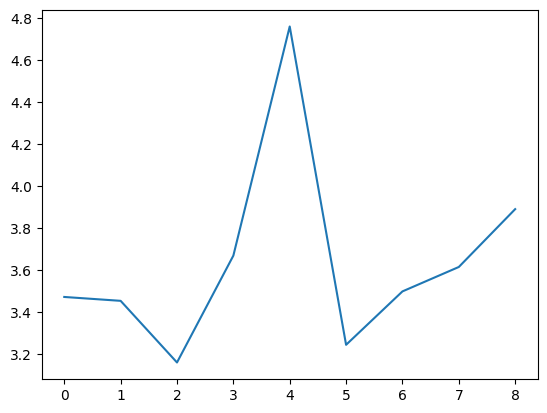

In [24]:
plt.plot(history.history['val_mae'])